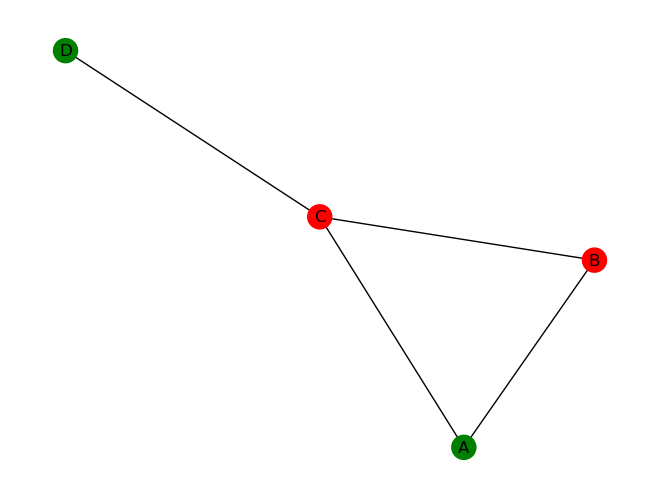

In [1]:
import graph_handler as gh
import fiduccia as fm
import networkx as nx
import metaheuristics as mh
import numpy as np
import bisect
MAX_COUNT = 10000
MAX_NO_IMPROV = 20
G1 = gh.createExampleGraph1()
gh.vizualize_graph(G1)

In [2]:
def hemming_distance(p1,p2):
    return sum([0 if p1[i]==p2[i] else 1 for i in range (0,len(p1))])

def invert_binary_list(p):
    return ["0" if p[i]=="1" else "1" for i in range(0,len(p))]

def uniformCrossover(p1,p2):
    hd=hemming_distance(p1,p2)
    if(hd>(len(p1)//2)):
        p2 = invert_binary_list(p2)
    balance = 0
    child = [-1]*len(p1)
    for i in range(0,len(p1)):
        if(abs(balance)>=len(p1)-i):
            ci = "0" if balance>0 else "1"
            incr = 1 if balance<0 else -1
            child[i]=ci
            balance+=incr
        elif(p1[i]==p2[i]):
            child[i] = p1[i]
            incr = 1 if p1[i]=="1" else -1
            balance+=incr
        else:
            apnd = np.random.choice([0,1])
            child[i]=str(apnd)
            incr = 1 if apnd==1 else -1
            balance+=incr
    assert(len(child)==len(p1) and balance==0)
    return child

"""
Places the first (non-sorted) item of the list in the correct position, shifting all other elements
"""
def insert(lst, item):
    #print(lst,item)
    # Searching for the position
    index=0
    for i in range(len(lst)-1,-1,-1):
      #print(i,lst[i],item)
      if lst[i][1] < item[1]:
        index = i+1
        break
    # Inserting n in the list
    if index == 0:
      lst = [item]+lst
    else:
      lst = lst[:index] + [item] + lst[index:]
    return lst




def linear_probabilities(items, k):
    #print(items[-1][1],items[0][1])
    spread = items[-1][1]-items[0][1]
    if(spread!=0):
        probabilities = [k ** (i[1] / (spread)) for i in items]
    else:
        probabilities=[i[1] for i in items]
    probabilities.reverse()
    #print(probabilities)
    sm = np.sum(probabilities)
    norm_probabilities = [x / sm for x in probabilities]
    #print(sum(norm_probabilities))
    return norm_probabilities

assert(linear_probabilities([["A",1],["B",2],["C",3],["D",4]],1)==[0.25,0.25,0.25,0.25])
assert(linear_probabilities([["A",1],["B",1],["C",1],["E",1]],10)==[0.25,0.25,0.25,0.25])


assert(hemming_distance(['1','1','1','1','1'],['0','0','0','0','0'])==5)
assert(hemming_distance(['1','1','1','1','1'],['1','1','1','1','1'])==0)
assert(hemming_distance(['1','1','1','1','1'],['0','1','1','0','1'])==2)
assert(invert_binary_list(["1","1","1",'1'])==['0','0','0','0'])
assert(invert_binary_list(['1','1','0','0'])==['0','0','1','1'])

print(uniformCrossover(['1','1','0','0'],['1','1','0','0']))

assert(uniformCrossover(["1","1","0","0"],["1","1","0","0"])==["1","1","0","0"])
assert(uniformCrossover(["1","1","1","1"],["0","0","0","0"])==["1","1","0","0"]) #This is expected due to the equality constriction (the parents are invalid in this case)
assert(uniformCrossover(["0","0","0","0"],["1","1","1","1"])==["0","0","1","1"]) #This is expected due to the equality constriction (the parents are invalid in this case)


assert(insert([(0,1),(1,3),("N",5),("G",7)],("X",4))==[(0,1),(1,3),("X",4),("N",5),("G",7)])
assert(insert([(0,1),(1,3),("N",5),("G",7)],("X",0))==[("X",0),(0,1),(1,3),("N",5),("G",7)])
assert(insert([(0,1),(1,3),("N",5),("G",7)],("X",10))==[(0,1),(1,3),("N",5),("G",7),("X",10)])
assert(insert([(0,1),(1,3),("N",5),("G",7)],("X",2))==[(0,1),("X",2),(1,3),("N",5),("G",7)])

assert(insert([[['1', '1', '0', '0'], 2], [['0', '1', '1', '0'], 3], [['1', '0', '0', '1'], 3], [['0', '1', '0', '1'], 3]],[['1', '1', '0', '0'],2])==(
   [[['1', '1', '0', '0'], 2], [['1', '1', '0', '0'], 2],[['0', '1', '1', '0'], 3], [['1', '0', '0', '1'], 3], [['0', '1', '0', '1'], 3]]
))

4 1
1 1
['1', '1', '0', '0']


In [3]:
import random
choices = [["A",1],["B",2],["C",3]]




In [7]:
from itertools import accumulate as _accumulate, repeat as _repeat

"""
The specific genetic algorithm is an incremental (or steady state) GA where there is no
explicit notion of generations: each iteration two parents are randomly selected, use
uniform crossover to generate one child, do FM local search on the child, let this
optimized child compete with the worst solution in the population, if it is better or
equal it replaces the worst solution.

Additional break, after 20 generations of no improvement in best cut, or cut average, the algorithm is stopped.
"""

def geneticSearch(G:nx.Graph,population:int, maxFmPass = 10000, selection_pressure:int=1):
    res,cntr,no_improv,prev_best,best_avg = [],0,0,np.inf,np.inf
    totalCuts = []
    #randomly initiate vertices in different colors
    pop=[[mh.createRandomPartition(G),np.inf] for i in range(0,population)]
    #calculate number of cuts for each population member
    for mem in pop:
        gh.setPartitionByBinaryList(G,mem[0])
        cut=gh.getCut(G)
        if(cut<prev_best):
            prev_best=cut
        mem[1]=cut
    #print(pop)
    #sort according to cutNumber
    pop.sort(key=lambda x: x[1])
    #print("Population",pop)
    while (cntr<maxFmPass):
        #print(len(pop),population,pop)
        assert(len(pop)==population)
        weighted_prop=linear_probabilities(pop,selection_pressure)
        p1,p2 = [weighted_prop[0],weighted_prop[0]]
        while(p1==p2):
            p1,p2= random.choices(range(0,len(pop)),weights=weighted_prop,k=2)
        child = uniformCrossover(pop[p1][0],pop[p2][0])
        #print(f"child {child} {pop[p1],pop[p2]}" )
        gh.setPartitionByBinaryList(G,child)
        #Improve the child through local search
        G,  lastCut, counter, allCuts=fm.fm_search(G)
        totalCuts.append(allCuts)
        binaryPart = gh.getListBinaryRepresentation(G)
        cntr+=counter
        #Compete with weakest population member
        #print("partition",binaryPart)
        if(lastCut<pop[-1][1]):
            pop.pop()#constant time removal of weakest member
            #print("Population1",pop)
            #print("Inserting",binaryPart,lastCut)
            pop=insert(pop,[binaryPart,lastCut]) #Linear time insert while maintining sorted status    
            #print("Population2",pop)
        minCut = pop[0][1]
        values = [x[1] for x in pop]
        # Calculate the mean
        average = np.mean(values)
        res.append([minCut,average])
        print(minCut,average,cntr)
        assert(not minCut>prev_best)
        if(prev_best<=minCut and average<=best_avg):
            no_improv+=1
        else:
            no_improv=0
            if(best_avg>average):
                best_avg=average
            if(prev_best>minCut):
                prev_best=minCut
        #if(no_improv>=MAX_NO_IMPROV):
        #    break
    return(res,cntr,pop[0][0], totalCuts)

print(geneticSearch(G1,5))
print(gh.getPartition(G1))

3 2
2 2.6 2
3 2
2 2.4 4
3 2
2 2.2 6
3 2
2 2.0 8
2 2
2 2.0 10
2 2
2 2.0 12
2 2
2 2.0 14
2 2
2 2.0 16
2 2
2 2.0 18
2 2
2 2.0 20
2 2
2 2.0 22
2 2
2 2.0 24
2 2
2 2.0 26
2 2
2 2.0 28
2 2
2 2.0 30
2 2
2 2.0 32
2 2
2 2.0 34
2 2
2 2.0 36
2 2
2 2.0 38
2 2
2 2.0 40
2 2
2 2.0 42
2 2
2 2.0 44
2 2
2 2.0 46
2 2
2 2.0 48
2 2
2 2.0 50
2 2
2 2.0 52
2 2
2 2.0 54
2 2
2 2.0 56
2 2
2 2.0 58
2 2
2 2.0 60
2 2
2 2.0 62
2 2
2 2.0 64
2 2
2 2.0 66
2 2
2 2.0 68
2 2
2 2.0 70
2 2
2 2.0 72
2 2
2 2.0 74
2 2
2 2.0 76
2 2
2 2.0 78
2 2
2 2.0 80
2 2
2 2.0 82
2 2
2 2.0 84
2 2
2 2.0 86
2 2
2 2.0 88
2 2
2 2.0 90
2 2
2 2.0 92
2 2
2 2.0 94
2 2
2 2.0 96
2 2
2 2.0 98
2 2
2 2.0 100
2 2
2 2.0 102
2 2
2 2.0 104
2 2
2 2.0 106
2 2
2 2.0 108
2 2
2 2.0 110
2 2
2 2.0 112
2 2
2 2.0 114
2 2
2 2.0 116
2 2
2 2.0 118
2 2
2 2.0 120
2 2
2 2.0 122
2 2
2 2.0 124
2 2
2 2.0 126
2 2
2 2.0 128
2 2
2 2.0 130
2 2
2 2.0 132
2 2
2 2.0 134
2 2
2 2.0 136
2 2
2 2.0 138
2 2
2 2.0 140
2 2
2 2.0 142
2 2
2 2.0 144
2 2
2 2.0 146
2 2
2 2.0 148
2 2
2 2.0 150
2 2

In [26]:

"""
The specific genetic algorithm is an incremental (or steady state) GA where there is no
explicit notion of generations: each iteration two parents are randomly selected, use
uniform crossover to generate one child, do FM local search on the child, let this
optimized child compete with the worst solution in the population, if it is better or
equal it replaces the worst solution.

Additional break, after 20 generations of no improvement in best cut, or cut average, the algorithm is stopped.
"""

def ilsGeneticSearch(G:nx.Graph,population:int, maxFmPass = 10000, selectionPressure=1,startNumberOfMutations=4):
    res,cntr,no_improv,prev_best,best_avg = [],0,0,np.inf,np.inf
    totalCuts = []
    #randomly initiate vertices in different colors
    pop=[[mh.createRandomPartition(G),np.inf] for i in range(0,population)]
    #calculate number of cuts for each population member
    for mem in pop:
        gh.setPartitionByBinaryList(G,mem[0])
        cut=gh.getCut(G)
        if(cut<prev_best):
            prev_best=cut
        mem[1]=cut
    #print(pop)
    #sort according to cutNumber
    pop.sort(key=lambda x: x[1])
    #print("Population",pop)
    while (cntr<maxFmPass):
        #print(len(pop),population,pop)
        assert(len(pop)==population)
        #randomly select two parents
        p1=np.random.randint(0,population-1)
        p2=p1
        while p2==p1: #makes sure parents are distinct
            p2=np.random.randint(0,population-1)
        child = uniformCrossover(pop[p1][0],pop[p2][0])
        for i in range(0,selectionPressure):
            mutatedSolution=mh.mutatePartition(child, numberOfMutations=startNumberOfMutations)
            gh.setPartitionByBinaryList(G, list(mutatedSolution))
            G, lastCut, cntFMPass, allCuts = fm.fm_search(G)
            cntr+=cntFMPass
            if(lastCut<pop[-1][1]):
                pop.pop()#constant time removal of weakest member
                pop=insert(pop,[mutatedSolution,lastCut]) #Linear time insert while maintining sorted status    
        minCut = pop[0][1]
        values = [x[1] for x in pop]
        # Calculate the mean
        average = np.mean(values)
        res.append([minCut,average,cntr])
        assert(not minCut>prev_best)
        if(prev_best<=minCut and average<=best_avg):
            no_improv+=1
        else:
            no_improv=0
            if(best_avg>average):
                best_avg=average
            if(prev_best>minCut):
                prev_best=minCut
        #if(no_improv>=MAX_NO_IMPROV):
        #    break
    return(res,cntr,pop[0][0], totalCuts)

    #G, partion, cut = fiduccia.fm_search(G)
print(ilsGeneticSearch(G1,5))
print(gh.getPartition(G1))

AssertionError: 

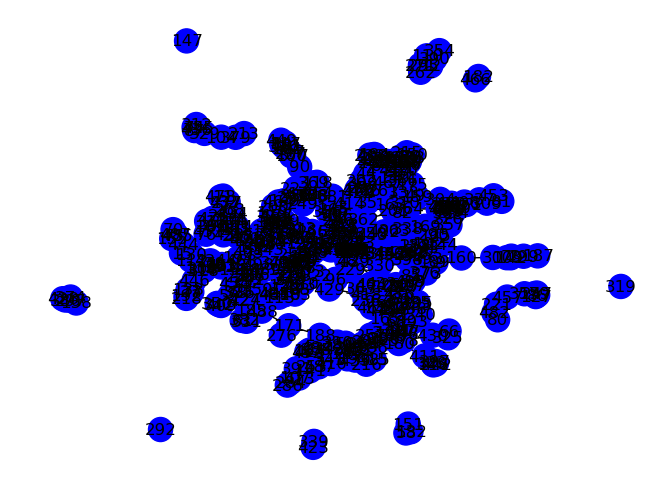

In [5]:
graphInit = gh.parse_graph("res/Graph500.txt", True)


In [27]:
res,cntr,bestpartition,_ = ilsGeneticSearch(graphInit, 50,maxFmPass=1000, selectionPressure=10)
print(res,cntr)

[[19, 515.84, 52], [13, 390.06, 111], [13, 268.8, 159], [13, 149.06, 209], [13, 34.36, 257], [13, 30.26, 316], [13, 29.16, 372], [13, 27.1, 415], [13, 27.1, 459], [13, 26.08, 509], [13, 25.92, 569], [13, 25.18, 618], [13, 24.22, 671], [13, 24.04, 719], [13, 23.92, 772], [13, 23.86, 824], [13, 23.46, 871], [13, 23.06, 931], [13, 23.06, 986], [13, 22.76, 1041]] 1041


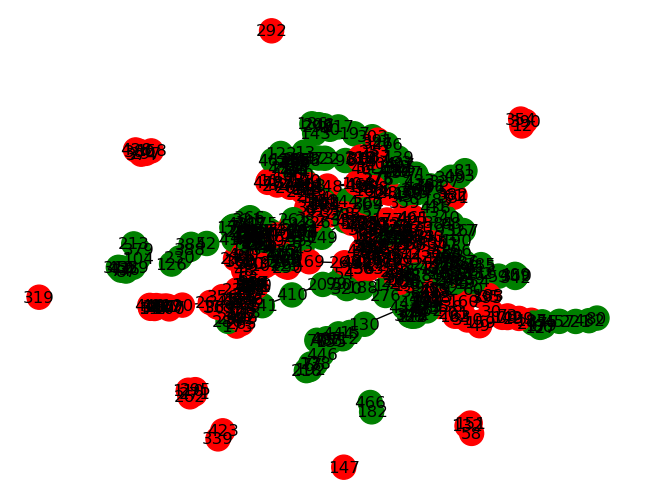

In [13]:
gh.setPartitionByBinaryList(graphInit,bestpartition)
gh.vizualize_graph(graphInit)

In [ ]:
print(genCuts)